# CPSC 4830 – Content-Based Movie Recommendation System with Generative AI

**Student:** Princewill Nwabuike  
**Course:** CPSC 4830 – Machine Learning  
**Project:** Movie Recommendation with Tag Genome & ChatGPT  
**Institution:** Langara College  

---

This notebook builds a **content-based movie recommendation system** using the MovieLens dataset and the **Tag Genome** (TagDL) scores.  
On top of the classical TF-IDF model, I integrate a **Generative AI (ChatGPT)** layer to generate human-readable explanations for recommendations.


## 1. Project Overview

The goal of this project is to recommend movies that are **similar in content** to a movie a user already likes.

**Key components:**

- **Data:** MovieLens metadata (titles, genres) + 2021 Tag Genome (TagDL) relevance scores.
- **Feature engineering:** For each movie, I build a text representation using:
  - Title  
  - Cleaned genres  
  - High-relevance Tag Genome tags
- **Model:** Content-based recommendation using **TF-IDF** features and **cosine similarity**.
- **Generative AI extension:** A **ChatGPT (OpenAI)** layer that:
  - Generates natural-language explanations for each recommendation.
  

This shows how **classical machine learning** and **Generative AI** can work together in a practical recommender system.


## 2. Environment Setup and Libraries

In this section, I install and import all the libraries needed for:

- Data handling and visualization (`pandas`, `numpy`, `matplotlib`)
- Text feature extraction and similarity
- Calling the **OpenAI ChatGPT API** for Generative AI explanations.


In [4]:
!pip install -U openai
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sklearn
from pylab import rcParams
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
import os
from getpass import getpass
from openai import OpenAI

## 3. Data Loading

I use the following datasets:

- **MovieLens movies metadata** – contains `movieId`, `title`, and `genres`.
- **TagDL scores** – Tag Genome relevance scores: `movieId`, `tagId`, `relevance`.




In [5]:
#Data loading


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



# Movie metadata (from MovieLens 25M or Latest)
movies = pd.read_csv("movies.csv")  # movieId,title,genres

# Tag Genome 2021 (choose one: glmer.csv or tagdl.csv from scores/)
scores = pd.read_csv("tagdl.csv")   # movieId, tagId, relevance
tags   = pd.read_json("tags.json", lines=True)  # id,name
tags   = tags.rename(columns={"id":"tagId","tag":"tag"})



### 3.1 Quick Data Inspection

Before modeling, I inspect the first few rows and check for missing values and basic data types.


In [6]:
# Quick peeks
print(movies.head(3))
movies.info()

print(scores.head(3))
scores.info()

print(tags.head(3))
tags.info()

   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
        tag  item_id     score
0  airplane        2  0.006687
1  airplane        3  0.004281
2  airplane        4 -0.000161
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10551655 entries, 0 to 10551654
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   tag      object 


In [7]:
#MİSSING VALUES
print(movies.isnull().sum())
print(scores.isnull().sum())
print(tags.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
tag        0
item_id    0
score      0
dtype: int64
tag      0
tagId    0
dtype: int64


In [8]:
#DUPLICATE VALUES
print(movies.duplicated().sum())
print(scores.duplicated().sum())
print(tags.duplicated().sum())

0
0
0


In [9]:
#VALUES TYPES
print(movies.dtypes)
print(scores.dtypes)
print(tags.dtypes)

movieId     int64
title      object
genres     object
dtype: object
tag         object
item_id      int64
score      float64
dtype: object
tag      object
tagId     int64
dtype: object


In [10]:
print("movies shape:", movies.shape)
print("scores shape:", scores.shape)
print("tags shape:", tags.shape)


movies shape: (62423, 3)
scores shape: (10551655, 3)
tags shape: (1094, 2)


## 4. Feature Engineering with Tag Genome (TagDL)

The Tag Genome provides a rich, fine-grained description of movies via:

- `tagId`: identifiers for semantic tags .
- `relevance`: how strongly a given tag applies to a movie.

**Steps:**

1. Merge TagDL scores with human-readable tag names.
2. Filter out low-relevance tags .
3. For each `movieId`, concatenate all remaining tags into a single string `tag_string`.


In [11]:
# Build a tag profile per movie using TagDL scores + tag names

RELEVANCE_THRESHOLD = 0.20

# 1. Attach tag names to the numeric scores
scores_tags = scores.merge(tags, left_on="tag", right_on="tag", how="left")
# scores_tags columns now: tag, item_id, score, tagId



# 2. Keep only reasonably relevant tags
scores_tags = scores_tags[scores_tags["score"] >= RELEVANCE_THRESHOLD]

# 3. Build a tag string per movie
movie_tags = (
    scores_tags
    .groupby("item_id")["tag"]
    .apply(lambda x: " ".join(x.astype(str).str.replace(" ", "_")))
    .reset_index()
    .rename(columns={"item_id": "movieId", "tag": "tag_string"})
)

movie_tags.head()



,movieId,tag_string
0,1,prison_escape intense surprise_ending underdog...
1,2,science monster intense eerie psychological ce...
2,3,realistic_action best_war_films cerebral fish ...
3,4,cerebral cult_classic visually_stunning pointl...
4,5,quirky cerebral slapstick ensemble_cast family...


## 5. Building Movie-Level Content Representation

To apply a content-based model, I create a **single text field** for each movie called `content` that combines:

- Title  
- Cleaned genres (replacing `|` with spaces)  
- High-relevance Tag Genome tags (`tag_string`)

I also extract the **release year** from the movie title to support basic filtering and EDA.


In [12]:
# Merge MovieLens metadata with the tag profiles
movies_merged = movies.merge(movie_tags, on="movieId", how="inner")

movies_merged["genres"] = movies_merged["genres"].fillna("")
movies_merged["tag_string"] = movies_merged["tag_string"].fillna("")

movies_merged["genres_clean"] = movies_merged["genres"].str.replace("|", " ", regex=False)

movies_merged["content"] = (
    movies_merged["title"].fillna("") + " " +
    movies_merged["genres_clean"] + " " +
    movies_merged["tag_string"]
)

movies_merged[["movieId", "title", "genres", "tag_string", "content"]].head()



,movieId,title,genres,tag_string,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,prison_escape intense surprise_ending underdog...,Toy Story (1995) Adventure Animation Children ...
1,2,Jumanji (1995),Adventure|Children|Fantasy,science monster intense eerie psychological ce...,Jumanji (1995) Adventure Children Fantasy scie...
2,3,Grumpier Old Men (1995),Comedy|Romance,realistic_action best_war_films cerebral fish ...,Grumpier Old Men (1995) Comedy Romance realist...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,cerebral cult_classic visually_stunning pointl...,Waiting to Exhale (1995) Comedy Drama Romance ...
4,5,Father of the Bride Part II (1995),Comedy,quirky cerebral slapstick ensemble_cast family...,Father of the Bride Part II (1995) Comedy quir...


In [13]:
# Cleaning up the year data in movies_merged
# Extract year from title and create 'year' column if missing
if 'year' not in movies_merged.columns:
    movies_merged['year'] = movies_merged['title'].str.extract(r'\((\d{4})\)').astype(float)

movies_merged = movies_merged.dropna(subset=['year'])
movies_merged['year'] = movies_merged['year'].astype(int)
movies_merged = movies_merged[(movies_merged['year'] >= 1900) & (movies_merged['year'] <= 2025)]
print(movies_merged['year'].describe())
movies_merged[['title', 'year']].head(10)


count    9585.000000
mean     1990.529682
std        18.498962
min      1902.000000
25%      1983.000000
50%      1996.000000
75%      2004.000000
max      2014.000000
Name: year, dtype: float64


,title,year
0,Toy Story (1995),1995
1,Jumanji (1995),1995
2,Grumpier Old Men (1995),1995
3,Waiting to Exhale (1995),1995
4,Father of the Bride Part II (1995),1995
5,Heat (1995),1995
6,Sabrina (1995),1995
7,Tom and Huck (1995),1995
8,Sudden Death (1995),1995
9,GoldenEye (1995),1995


### 5.1 Exploratory Data Analysis (EDA)

Here I briefly explore:

- The distribution of movie release years.
- The frequency of different genres in the dataset.


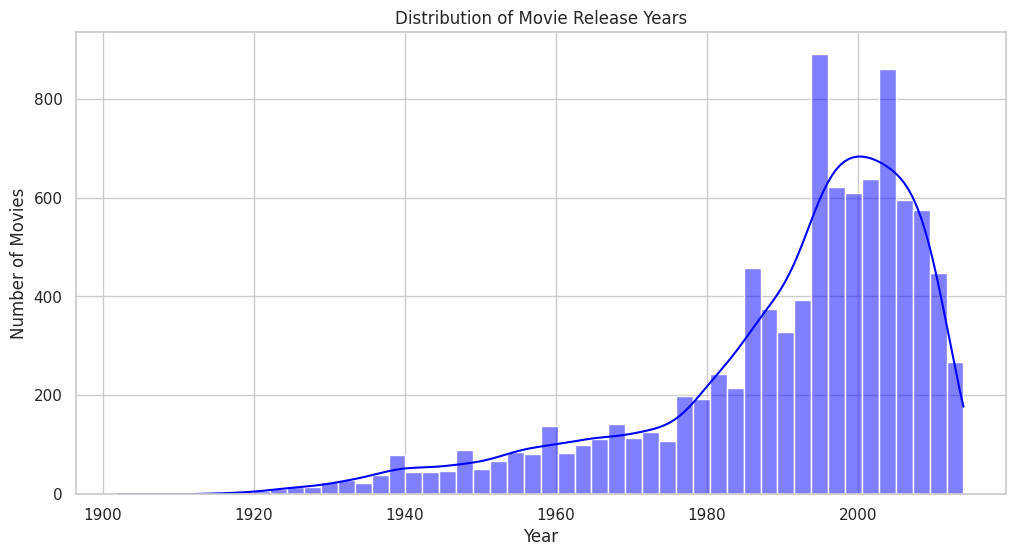

In [14]:
# Create a histogram of movie release years
plt.figure(figsize=(12, 6))
sns.histplot(movies_merged['year'], bins=50, kde=True, color='blue')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

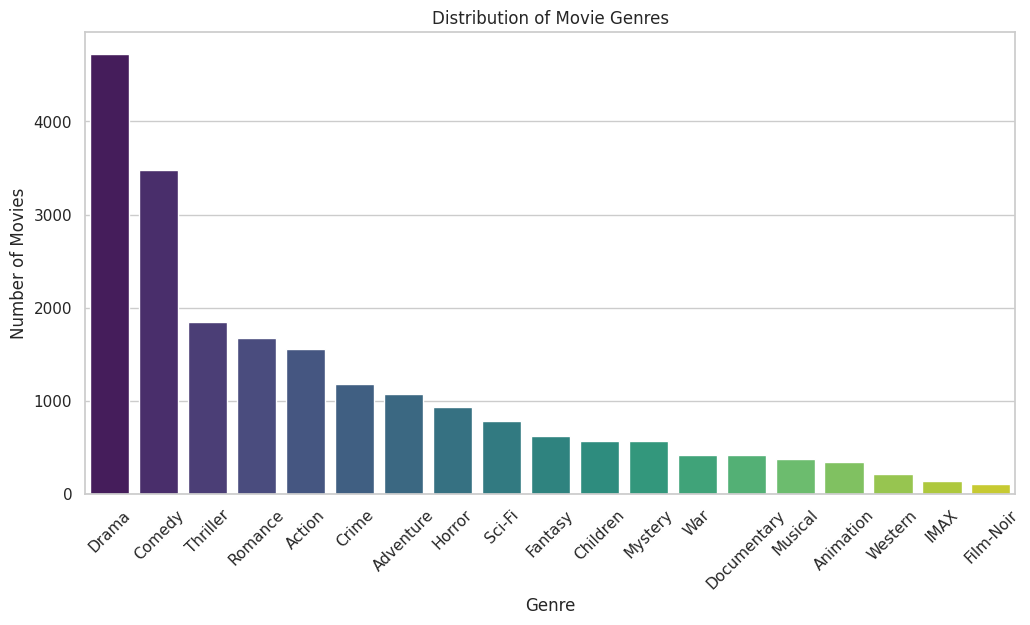

In [15]:
# Create a bar plot of genre distribution
genres_exploded = movies_merged['genres'].str.split('|', expand=True)
genre_counts = genres_exploded.stack().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [16]:
#Size of the merged dataset
movies_merged.shape

(9585, 7)

## 6. Content-Based Recommendation Model (TF-IDF + Cosine Similarity)

I use a **content-based** approach:

1. Apply **TF-IDF** to the `content` field to obtain a high-dimensional vector for each movie.
2. Compute **cosine similarity** between movies.
3. Given a movie title, return the top-N most similar movies based on cosine similarity.

This approach does not require user ratings; it uses only movie metadata and tags.


In [17]:
#TF-IDF + recommendation function

tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies_merged["content"])

indices = (
    pd.Series(movies_merged.index, index=movies_merged["title"].str.lower())
    .drop_duplicates()
)

def get_recommendations(title, n_recs=10):
    title_key = title.lower()
    if title_key not in indices:
        print(f"'{title}' not found.")
        return None

    idx = indices[title_key]

    sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    sim_idx = sim_scores.argsort()[::-1]
    sim_idx = [i for i in sim_idx if i != idx][:n_recs]

    results = movies_merged.iloc[sim_idx][["movieId", "title", "genres"]].copy()
    results["similarity"] = sim_scores[sim_idx]
    return results



In [18]:

#Test:

recs = get_recommendations("Jumanji (1995)", n_recs=5)
print(recs)



      movieId                            title  \
1785     2054  Honey, I Shrunk the Kids (1989)   
3069     3489                      Hook (1991)   
300       317         Santa Clause, The (1994)   
1890     2161    NeverEnding Story, The (1984)   
2132     2429          Mighty Joe Young (1998)   

                                        genres  similarity  
1785  Adventure|Children|Comedy|Fantasy|Sci-Fi    0.639153  
3069                  Adventure|Comedy|Fantasy    0.557351  
300                       Comedy|Drama|Fantasy    0.552997  
1890                Adventure|Children|Fantasy    0.551649  
2132   Action|Adventure|Drama|Fantasy|Thriller    0.544061  


In [19]:
#Another test
recommendations = get_recommendations("Father of the Bride Part II (1995)", n_recs=5)
print(recommendations)


      movieId                            title          genres  similarity
5823     6944       Father of the Bride (1991)          Comedy    0.599980
320       339   While You Were Sleeping (1995)  Comedy|Romance    0.506616
173       186               Nine Months (1995)  Comedy|Romance    0.504105
1374     1569  My Best Friend's Wedding (1997)  Comedy|Romance    0.495895
830       934       Father of the Bride (1950)          Comedy    0.495564


## 7. OpenAI / ChatGPT Configuration

To integrate Generative AI, I use the **OpenAI ChatGPT API**.

- The API key is entered securely using `getpass()` so it is not stored in the notebook.
- The key is saved in an environment variable and used to create a reusable `OpenAI` client.


In [20]:

# Ask for your key (input is hidden)
api_key = getpass("Enter your OpenAI API key: ")

# Store in environment so the client can read it
os.environ["OPENAI_API_KEY"] = api_key

# Create client to read OPENAI_API_KEY automatically
client = OpenAI()


Enter your OpenAI API key: ··········


## 8. Generative AI Layer: Explaining Recommendations with ChatGPT

While TF-IDF and cosine similarity are effective, the **raw similarity scores are not intuitive** for end users.

To improve transparency and user trust, I add a **Generative AI layer** using the OpenAI ChatGPT API:

- For each recommended movie, I send:
  - The source movie’s title, genres, and Tag Genome tags.
  - The recommended movie’s title, genres, and tags.
- ChatGPT generates a **2–3 sentence explanation** describing why the recommendation is a good match.

This separates:
- *What* to recommend (classical ML), from  
- *How* to explain it (Generative AI).


In [21]:

def explain_recommendation_with_llm(source_row, rec_row, model_name="gpt-4.1-mini"):
    """
    Use ChatGPT (OpenAI API) to explain why rec_row is a good
    recommendation for a user who liked source_row.
    """
    source_title = source_row["title"]
    source_genres = source_row.get("genres", "")
    source_tags = source_row.get("tag_string", "")

    rec_title = rec_row["title"]
    rec_genres = rec_row.get("genres", "")
    rec_tags = rec_row.get("tag_string", "")

    prompt = f"""
You are part of a movie recommendation system.

A user liked this movie:
- Title: {source_title}
- Genres: {source_genres}
- Tags: {source_tags}

We are recommending this movie:
- Title: {rec_title}
- Genres: {rec_genres}
- Tags: {rec_tags}

In 2–3 sentences, explain why the recommended movie is a good match.
Focus on similarities in genre, themes, mood, or audience.
Avoid spoilers.
Use friendly, simple language.
"""

    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You explain movie recommendations clearly and concisely."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=150,
    )

    return response.choices[0].message.content.strip()


### 8.1 Demo: Recommendations with Natural-Language Explanations

Below, I:

1. Request the top-5 movies similar to **"GoldenEye (1995)"** using the TF-IDF model.
2. For each recommendation, call ChatGPT to generate a short explanation.

This demonstrates the **full pipeline**: content-based ranking + Gen AI explanation.


In [22]:
source_title = "GoldenEye (1995)"

# Your existing function
recs = get_recommendations(source_title, n_recs=5)

source_row = movies_merged[movies_merged["title"] == source_title].iloc[0]

for _, rec_row in recs.iterrows():
    print(f"Recommendation: {rec_row['title']} (similarity={rec_row['similarity']:.3f})")
    explanation = explain_recommendation_with_llm(source_row, rec_row)
    print("Why:", explanation)
    print("-" * 80)


Recommendation: World Is Not Enough, The (1999) (similarity=0.666)
Why: If you enjoyed GoldenEye's thrilling mix of action, espionage, and intense spy drama, The World Is Not Enough offers a similar blend of high-stakes adventure and suspense. Both movies feature exciting missions, complex characters, and that classic James Bond style, making it a perfect follow-up for fans of action-packed, stylish spy stories.
--------------------------------------------------------------------------------
Recommendation: Spy Who Loved Me, The (1977) (similarity=0.666)
Why: If you enjoyed GoldenEye's thrilling mix of action, adventure, and spy intrigue, The Spy Who Loved Me is a perfect pick with its classic James Bond excitement and suspense. Both movies deliver fast-paced chases, clever espionage, and stylish heroes, making it a fun and captivating watch for fans of the spy genre. You'll love the blend of intense action and charismatic storytelling that keeps you hooked from start to finish.
------

## 9. Conclusion

In this project, I implemented a **content-based movie recommendation system** using MovieLens metadata and Tag Genome tags.  
Movies are converted into TF-IDF vectors over titles, genres, and high-relevance tags, and **cosine similarity** is used to identify similar movies.

On top of this classical model, I integrated a **Generative AI (ChatGPT) layer**:

- For each recommendation, ChatGPT generates a short, natural-language explanation of *why* the movie is a good match.
- This separation between the **ranking model** and the **explanation model** makes the system both effective and interpretable.

**Key takeaways:**

- Traditional ML methods remain very powerful for recommendation tasks.
- Generative AI is most useful when used to enhance **interpretability**, **interaction**, and **user experience**, rather than replace the core model.
- The combination of TF-IDF + Tag Genome + ChatGPT provides a flexible framework that can be extended in multiple directions.

Overall, this project shows how **classical recommender techniques and modern Generative AI** can be combined into a practical, explainable movie recommendation system.
